In [74]:
import torch
import torchvision
import random
import os

import cv2 as cv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

PATH = './emnist.pth'

## Download/load data

In [79]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5), (0.5))
    ]
)

batch_size = 5

train_set = torchvision.datasets.EMNIST(
    root='./data',
    split="byclass",
    train=True,
    download=True, 
    transform=transform
)

test_set = torchvision.datasets.EMNIST(
    root='./data', 
    split="byclass",
    train=False,
    download=True, 
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = train_loader.dataset.class_to_idx
number_of_classes = len(classes.keys())

def get_class_name(class_index):
    for name, index in classes.items():
        if index == class_index:
            return name

## Visualizing classes

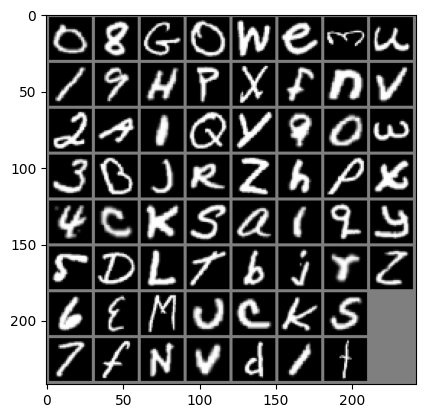

0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z


In [143]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (2, 1, 0)))
    plt.show()

images = []
for cls in classes.values():
    for img, label in train_set:
        if label == cls:            
            images.append(img)
            break

imshow(torchvision.utils.make_grid(images))
print(' '.join(classes.keys()))

## CNN Definition

In [80]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_of_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        # if i % 2000 == 1999: # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0

    print(f"Epoch {epoch}: loss: {running_loss}")

print('Finished Training')

## Saving trained network

In [ ]:
torch.save(net.state_dict(), PATH)

## Loading trained network

In [81]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Testing the network

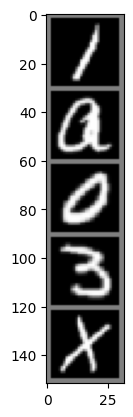

True Label:  I a 0 3 X
Predicted:  1 a 0 3 X


In [144]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('True Label: ', ' '.join(get_class_name(label) for label in labels))

outputs = net(images)
_, predicted_labels = torch.max(outputs, 1)

print('Predicted: ', ' '.join(get_class_name(label) for label in predicted_labels))

### Overall Accuracy

In [146]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 85 %


### Per class prediction

In [147]:
correct_pred = {classname: 0 for classname in classes.keys()}
total_pred = {classname: 0 for classname in classes.keys()}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[get_class_name(label)] += 1
            total_pred[get_class_name(label)] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 69.3 %
Accuracy for class: 1     is 95.2 %
Accuracy for class: 2     is 95.6 %
Accuracy for class: 3     is 99.1 %
Accuracy for class: 4     is 97.7 %
Accuracy for class: 5     is 94.2 %
Accuracy for class: 6     is 98.2 %
Accuracy for class: 7     is 99.2 %
Accuracy for class: 8     is 96.7 %
Accuracy for class: 9     is 97.9 %
Accuracy for class: A     is 96.5 %
Accuracy for class: B     is 94.6 %
Accuracy for class: C     is 92.8 %
Accuracy for class: D     is 86.4 %
Accuracy for class: E     is 94.6 %
Accuracy for class: F     is 70.8 %
Accuracy for class: G     is 84.8 %
Accuracy for class: H     is 94.0 %
Accuracy for class: I     is 45.8 %
Accuracy for class: J     is 83.2 %
Accuracy for class: K     is 83.8 %
Accuracy for class: L     is 91.5 %
Accuracy for class: M     is 98.2 %
Accuracy for class: N     is 97.4 %
Accuracy for class: O     is 65.9 %
Accuracy for class: P     is 95.9 %
Accuracy for class: Q     is 82.6 %
Accuracy for class: R     is

## Getting random captcha

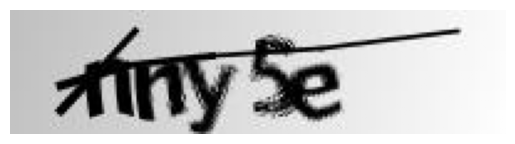

nny5e


In [84]:
# captchas = os.listdir('./new_captcha_dataset')
# def get_random_captcha():
#     selected_captcha = captchas[random.randint(0, len(captchas))]
#     solution = selected_captcha[0:-4]

#     image_path = os.path.join("./captcha_dataset", selected_captcha)
#     image = plt.imread(image_path)
#     return image, solution

# captcha, solution = get_random_captcha()
# plt.imshow(captcha)
# plt.axis('off')
# plt.show()
# print(solution)

## Processing new captchas

In [141]:
def split_captcha(number, upscale=5, max_iters=1_000, show_processed_image=False):
    img = cv.imread(f'new_captcha_dataset/{number}.png')
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Upscales image
    dim = imgray.shape[:2]
    imgray = cv.resize(imgray, (dim[1]*upscale, dim[0]*upscale))
            
    # Denoise
    _, processed_img = cv.threshold(imgray, 127, 255, cv.THRESH_TRUNC + cv.THRESH_OTSU)
    _, processed_img = cv.threshold(processed_img, 115, 255, cv.THRESH_BINARY_INV)

    if show_processed_image:
        # Display processed captcha
        plt.imshow(processed_img)

    # Find contours in captcha
    contours , _ = cv.findContours(processed_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    # Iterate through the found contours until there are exactly 5
    curr_threshold = 100
    iterations = 0
    while iterations < max_iters:
        digit_contours = []
        for contour in contours:
            digit_pixels = cv.contourArea(contour)
            bounding_box = cv.boundingRect(contour)

            threshold = curr_threshold * upscale
            if digit_pixels > threshold:
                digit_contours.append(bounding_box)

        if len(digit_contours) == 5:
            break
        elif len(digit_contours) > 5:
            curr_threshold += 1
        elif len(digit_contours) < 5:
            curr_threshold -= 1
        iterations += 1
    
    if len(digit_contours) != 5:
        return

    digit_contours = sorted(digit_contours, key = lambda contour : contour[0])
    
    digits = []
    for contour in digit_contours:

        # Get digit boundaries and cut it from main captcha
        start_x, end_x = contour[0], contour[0] + contour[2]
        start_y, end_y = contour[1], contour[1] + contour[3]
        digit = processed_img[start_y : end_y, start_x : end_x]
        
        # Upscale digit
        digit_dim = digit.shape[:2]
        digit = cv.resize(digit, (digit_dim[1]*upscale, digit_dim[0]*upscale))

        # Downscale to 28x28
        digit = cv.resize(digit, (28, 28))

        digit = digit[np.newaxis, :, :]
        digits.append(digit)
    
    return torch.Tensor(np.array(digits))

### Predicting new captchas...

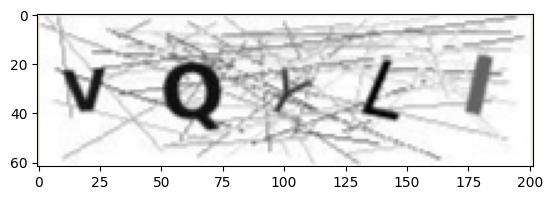

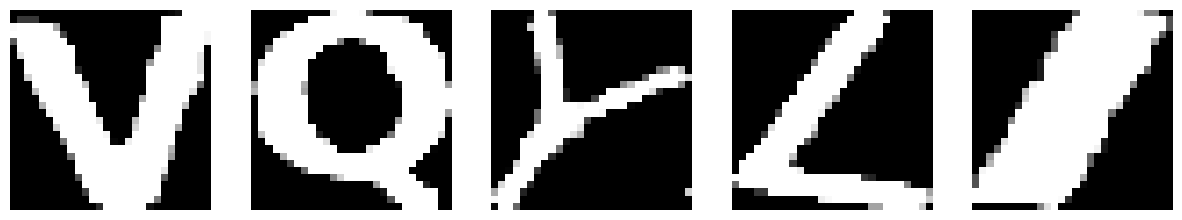

Predicted: 2QXAA


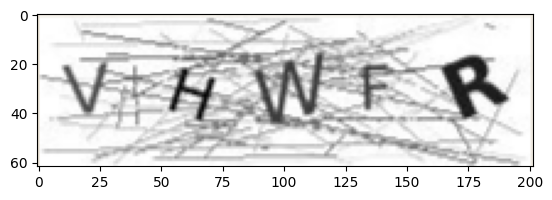

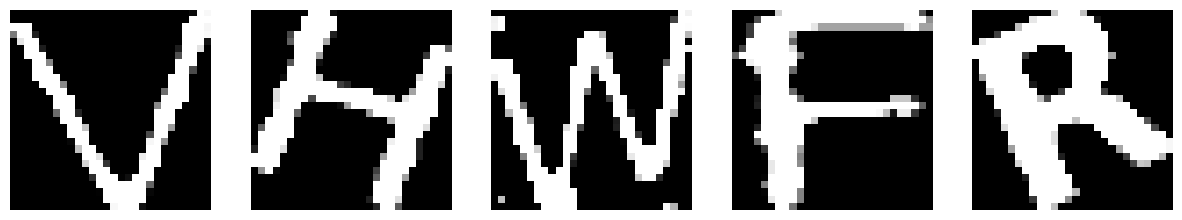

Predicted: 3QBGW


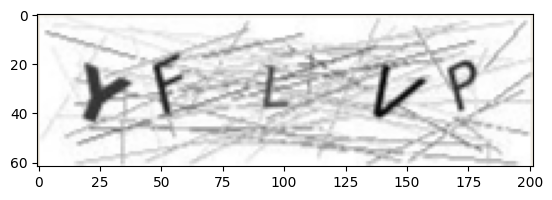

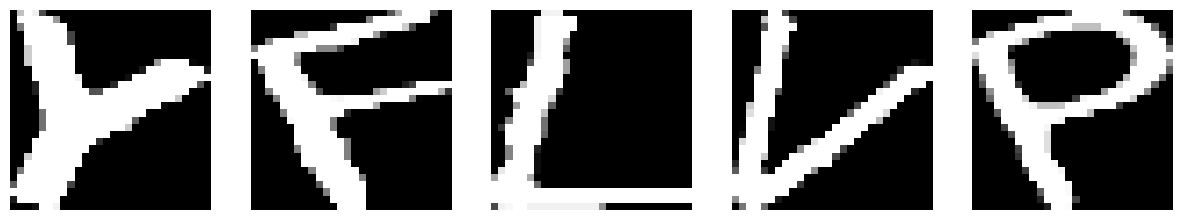

Predicted: KMQUq


In [149]:
max_iters = 1_000
for captcha in range(10, 13):

    digits = split_captcha(captcha, upscale=5, max_iters=100)

    plt.imshow(cv.imread(f'new_captcha_dataset/{captcha}.png'))
    plt.show()

    if digits == None:
        print("Couldn't find contours")
        continue


    fig, axs = plt.subplots(1, len(digits), figsize=(15, 3))
    for i, digit in enumerate(digits):
        axs[i].imshow(digit.numpy().reshape(28,28), cmap='gray')
        axs[i].axis('off')
    plt.show()

    with torch.no_grad():
        prediction = []
        outputs = net(digits)
        _, predicted = torch.max(outputs.data, 1)
        
    print('Predicted:', ''.join(get_class_name(label) for label in predicted))